# Decision Tree Classification

Decision trees are a popular and effective machine learning technique used for classification problems. The basic idea of a decision tree is to recursively partition the data into subsets that are more homogeneous with respect to the target variable. At each node of the tree, a decision is made based on one of the features that is used to split the data into two or more subsets. This process continues until the data in each subset is as homogeneous as possible, or until some stopping criteria are met.

In this notebook, we will explore how to use decision trees for classification problems using PySpark. Specifically, we will use the famous Iris dataset, which contains information about the physical characteristics of three different types of iris flowers, to build a decision tree model that can predict the type of iris flower based on its features. We will cover the following topics:

- Loading and preparing the data
- Training a decision tree model using PySpark's MLlib library
- Evaluating the model's performance using various metrics
- Tuning the model's hyperparameters to improve its performance

By the end of this notebook, you should have a good understanding of how decision trees work and how to apply them to real-world classification problems using PySpark.

## Introduction

### Description of the dataset iris

The iris dataset is a classic and widely used dataset in machine learning and statistics. It contains measurements of the sepal length, sepal width, petal length, and petal width for 150 iris flowers, with 50 samples from each of three different species (setosa, versicolor, and virginica). The dataset was first introduced in a 1936 paper by the British statistician and biologist Ronald Fisher, and has since become a popular example for exploring and practicing machine learning algorithms.

The iris dataset is often used for classification tasks, as the goal is to predict the species of an iris flower based on its measurements. It is also a good dataset for exploring and visualizing data, as the different species have distinct characteristics that can be easily visualized with scatter plots or other techniques.

Overall, the iris dataset is a useful and interesting dataset for anyone working in the fields of machine learning, statistics, or data science.

### Importing necessary libraries and download dataset 

In [49]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [1]:
# download the dataset iris
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data --output iris.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4551  100  4551    0     0   3355      0  0:00:01  0:00:01 --:--:--  3353


In [6]:
# create schema for easy human read 
schema_iris = 'sepal_length FLOAT, sepal_width FLOAT, petal_length FLOAT, petal_width FLOAT, class STRING'

# init SparkSession
spark = SparkSession.builder.appName('DecisionTreeClassifier').getOrCreate()
# read the csv using pyspark
iris = spark.read.csv('./iris.csv', schema=schema_iris, header=False)

# print few lines of the dataframe
iris.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|      class|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



## Exploratory Data Analysis

### Summary statistics of the dataset

In this section, we will explore the iris datasets giving some statistic description like mean, std, etc.

In [8]:
# overview of the dataset
iris.select('sepal_length', 'sepal_width', 'petal_length', 'petal_width').describe().show()

+-------+------------------+-------------------+------------------+------------------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|
+-------+------------------+-------------------+------------------+------------------+
|  count|               150|                150|               150|               150|
|   mean| 5.843333326975505| 3.0540000025431313|3.7586666552225747| 1.198666658103466|
| stddev|0.8280661128539085|0.43359431104332985|1.7644204144315179|0.7631607319020202|
|    min|               4.3|                2.0|               1.0|               0.1|
|    max|               7.9|                4.4|               6.9|               2.5|
+-------+------------------+-------------------+------------------+------------------+



In [9]:
# uique classes
iris.select('class').distinct().show()

+---------------+
|          class|
+---------------+
| Iris-virginica|
|    Iris-setosa|
|Iris-versicolor|
+---------------+



## Data Preparation

### Splitting the dataset into training and testing sets

In [55]:
train, test = iris.randomSplit([0.8, 0.2])

### Preprocessing the data (e.g., scaling, normalization, encoding)

Here we will use the RFormula to separate and treat the dataframe and the MinMaxScaller

In [56]:
formula = RFormula(formula='class ~ .', featuresCol='features', labelCol='label')
# only to see if everything is ok
formula.fit(train).transform(train).show(5, truncate=False)

+------------+-----------+------------+-----------+-----------+----------------------------------------------------------------------------+-----+
|sepal_length|sepal_width|petal_length|petal_width|class      |features                                                                    |label|
+------------+-----------+------------+-----------+-----------+----------------------------------------------------------------------------+-----+
|4.3         |3.0        |1.1         |0.1        |Iris-setosa|[4.300000190734863,3.0,1.100000023841858,0.10000000149011612]               |0.0  |
|4.4         |3.0        |1.3         |0.2        |Iris-setosa|[4.400000095367432,3.0,1.2999999523162842,0.20000000298023224]              |0.0  |
|4.4         |3.2        |1.3         |0.2        |Iris-setosa|[4.400000095367432,3.200000047683716,1.2999999523162842,0.20000000298023224]|0.0  |
|4.5         |2.3        |1.3         |0.3        |Iris-setosa|[4.5,2.299999952316284,1.2999999523162842,0.30000001192

In [57]:
# IMPORTANT only fit the scaler using the training set
temp = formula.fit(train).transform(train)
scaler = MinMaxScaler(inputCol='features', outputCol='features_norm')
# only to see if everything is ok
scaler.fit(temp).transform(temp).select('features', 'features_norm').show(5, truncate=False)

+----------------------------------------------------------------------------+----------------------------------------------------------------------------------+
|features                                                                    |features_norm                                                                     |
+----------------------------------------------------------------------------+----------------------------------------------------------------------------------+
|[4.300000190734863,3.0,1.100000023841858,0.10000000149011612]               |[0.0,0.41666665010982157,0.016949156309400068,0.0]                                |
|[4.400000095367432,3.0,1.2999999523162842,0.20000000298023224]              |[0.027777752022683674,0.41666665010982157,0.0508474487232362,0.041666667313418455]|
|[4.400000095367432,3.200000047683716,1.2999999523162842,0.20000000298023224]|[0.027777752022683674,0.5,0.0508474487232362,0.041666667313418455]                |
|[4.5,2.299999952316284,1.29

## Model Training

### Building a Decision Tree Classifier model

In [58]:
# the labelCol will be the as same as labelCol of RFormula and featuresCol will be the same of outputCol of scaler
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features_norm")

In [59]:
# building all together
pipeline = Pipeline(stages=[formula, scaler, dt])

### Training the model on the training set

In [60]:
model = pipeline.fit(train)

### Evaluating the performance of the model on the test set 

In [61]:
prd = model.transform(test)
prd.show(5)

+------------+-----------+------------+-----------+---------------+--------------------+-----+--------------------+--------------+-------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|          class|            features|label|       features_norm| rawPrediction|  probability|prediction|
+------------+-----------+------------+-----------+---------------+--------------------+-----+--------------------+--------------+-------------+----------+
|         4.4|        2.9|         1.4|        0.2|    Iris-setosa|[4.40000009536743...|  0.0|[0.02777775202268...|[42.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.6|        3.2|         1.4|        0.2|    Iris-setosa|[4.59999990463256...|  0.0|[0.08333325606805...|[42.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.8|        3.0|         1.4|        0.1|    Iris-setosa|[4.80000019073486...|  0.0|[0.13888889256818...|[42.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.9|        2.4|         3.3|        1.0|Iris-versicol

In [62]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(prd)

0.9259259259259259

## Model Tuning and Interpretation

### Fine-tuning the model (e.g., hyperparameter tuning)

In [63]:
# to this I will use the param grid search and selection present in pyspark
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit

dt_param_builder = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])
             .build())
pipeline = Pipeline(stages=[formula, scaler, dt])
tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=dt_param_builder, evaluator=evaluator, trainRatio=0.8)

In [64]:
model2 = tvs.fit(train)

In [65]:
prd2 = model2.transform(test)
prd2.show(5)

+------------+-----------+------------+-----------+---------------+--------------------+-----+--------------------+--------------+--------------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|          class|            features|label|       features_norm| rawPrediction|         probability|prediction|
+------------+-----------+------------+-----------+---------------+--------------------+-----+--------------------+--------------+--------------------+----------+
|         4.4|        2.9|         1.4|        0.2|    Iris-setosa|[4.40000009536743...|  0.0|[0.02777775202268...|[42.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|         4.6|        3.2|         1.4|        0.2|    Iris-setosa|[4.59999990463256...|  0.0|[0.08333325606805...|[42.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|         4.8|        3.0|         1.4|        0.1|    Iris-setosa|[4.80000019073486...|  0.0|[0.13888889256818...|[42.0,0.0,0.0]|       [1.0,0.0,0.0]|       0.0|
|         4.9|        

In [66]:
evaluator.evaluate(prd2)

0.9629629629629629

### Interpreting the results of the model 

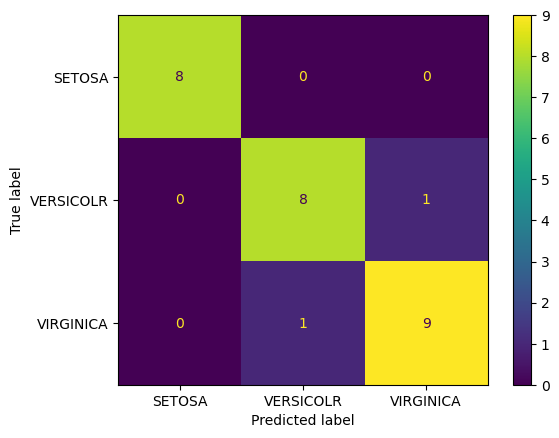

In [77]:
from sklearn import metrics
import matplotlib.pyplot as plt

df_prd = prd.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd['label'], df_prd['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['SETOSA','VERSICOLR','VIRGINICA'])
cm_display.plot()
plt.show()

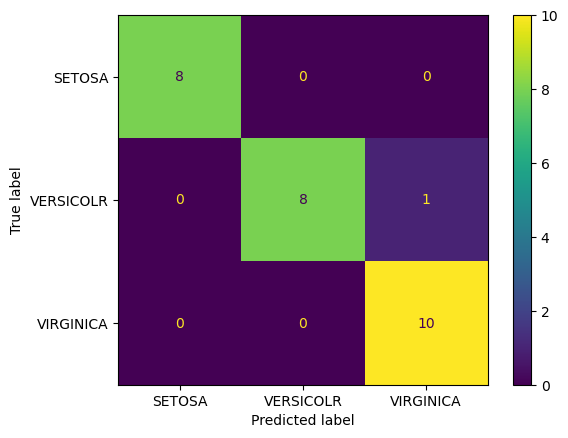

In [78]:
df_prd2 = prd2.select('label', 'prediction').toPandas()
cm = metrics.confusion_matrix(df_prd2['label'], df_prd2['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['SETOSA','VERSICOLR','VIRGINICA'])
cm_display.plot()
plt.show()

In [ ]:
spark.stop()